Sarcasm Detection 

In [ ]:
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based
supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to
other tweets and detecting sarcasm in these requires the availability of contextual tweets.In this hands-on project,
the goal is to build a model to detect whether a sentence is sarcastic or not, using Bidirectional LSTMs.

The dataset is collected from two news websites, theonion.com and huffingtonpost.com.
This new dataset has the following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This
reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as
compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in teasing apart the
real sarcastic elements
Content: Each record consists of three attributes:
is_sarcastic: 1 if the record is sarcastic otherwise 0
headline: the headline of the news article
article_link: link to the original news article. Useful in collecting supplementary data
Reference: https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

PROJECT OBJECTIVE: Build a sequential NLP classifier which can use input text parameters to determine the
customer sentiments.

Steps and tasks:  
1. Read and explore the data 

In [ ]:
import pandas as pd
df = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)

In [12]:
print("The data is:")
print(df.head())

The data is:
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  


2. Retain relevant columns 

In [13]:
df.drop("article_link", axis=1, inplace=True)

In [14]:
print("The data is:")
print(df.head())

The data is:
   is_sarcastic                                           headline
0             1  thirtysomething scientists unveil doomsday clo...
1             0  dem rep. totally nails why congress is falling...
2             0  eat your veggies: 9 deliciously different recipes
3             1  inclement weather prevents liar from getting t...
4             1  mother comes pretty close to using word 'strea...


In [15]:
print("The number of items in data is:",len(df))

The number of items in data is: 28619


3. Get length of each sentence 

In [16]:
print('Length of headlines:',df['headline'].str.len())

Length of headlines: 0        61
1        79
2        49
3        52
4        61
         ..
28614    44
28615    87
28616    71
28617    61
28618    34
Name: headline, Length: 28619, dtype: int64


4. Define parameters  

In [17]:
def remove_special_characters(dataframe,columnname):
    dataframe_no_special_characters = dataframe[columnname].replace(r'[^A-Za-z0-9 ]+', '', regex=True)
    return dataframe_no_special_characters

df['headline'] = remove_special_characters(df,'headline')

In [18]:
def lowercase(dataframe,columnname):
    lowercase_dataframe = dataframe[columnname].apply(lambda x: x.lower())
    return lowercase_dataframe

df['headline'] = lowercase(df,'headline')

In [19]:
from nltk.tokenize import word_tokenize

def tokenize_words(dataframe,columnname):
    dataframe_tokenized_texts= dataframe[columnname].apply(lambda x: word_tokenize(x) )
    
    return dataframe_tokenized_texts

df['headline'] = tokenize_words(df,'headline')

In [20]:
from nltk.corpus import stopwords

def remove_stop_words(dataframe,columnname):
    stop = stopwords.words('english')
    dataframe_no_stop_words= dataframe[columnname].apply(lambda x: [item for item in x if item not in stop])
    
    return dataframe_no_stop_words

df['headline'] = remove_stop_words(df,'headline')

In [21]:
def join_sentence(dataframe,columnname):

    dataframe_joined_sentence= dataframe[columnname].apply(lambda x: (" ").join(x))    
    return dataframe_joined_sentence

df['headline'] = join_sentence(df,'headline')

In [22]:
print("The new data is:")
print(df.head())

The new data is:
   is_sarcastic                                           headline
0             1  thirtysomething scientists unveil doomsday clo...
1             0  dem rep totally nails congress falling short g...
2             0        eat veggies 9 deliciously different recipes
3             1       inclement weather prevents liar getting work
4             1  mother comes pretty close using word streaming...


In [23]:
df['number_of_words'] = df['headline'].apply(lambda x: len(x.split(' ')))

In [24]:
print("The new data is:")
print(df.head())

The new data is:
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep totally nails congress falling short g...   
2             0        eat veggies 9 deliciously different recipes   
3             1       inclement weather prevents liar getting work   
4             1  mother comes pretty close using word streaming...   

   number_of_words  
0                7  
1               10  
2                6  
3                6  
4                8  


5. Get indices for words 

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_features=10000

tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(df['headline']))

6. Create features and labels 

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

X = tokenizer.texts_to_sequences(df['headline'])

max_number_of_words = df['number_of_words'].max()

X = pad_sequences(X, maxlen = max_number_of_words)
y = np.asarray(df['is_sarcastic'])

7. Get vocabulary size  

In [27]:
vocabulory_size = len(tokenizer.word_index) + 1
print('Vocabulary size/Numer of unique tokens:', vocabulory_size)

Vocabulary size/Numer of unique tokens: 29509


8. Create a weight matrix using GloVe embeddings 

In [28]:
#Extract  
from zipfile import ZipFile
with ZipFile('glove.6B.zip', 'r') as z:
  z.extractall()

In [29]:
glove_embeddings = {}

for item in open('glove.6B.200d.txt',errors="ignore"):
    word = item.split(' ')[0]
    embed = item.split(' ')[1:]
    embed = np.asarray(embed, dtype = 'float32')
    glove_embeddings[word] = embed

In [30]:
# Getting the minimum number of words
minimum_number_words = min(max_features, vocabulory_size) + 1

embedding_size = 200

embedding_matrix = np.zeros((minimum_number_words, embedding_size))

for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

9. Define and compile a Bidirectional LSTM model. 
Hint: Be analytical and experimental here in trying new approaches to design the best model.

In [32]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.initializers import Constant

model = Sequential()
model.add(Embedding(minimum_number_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = max_number_of_words, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

In [35]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

10. Fit the model and check the validation accuracy  

In [36]:
model.fit(X_train, y_train, epochs = 10, validation_split = 0.2, batch_size = 100, verbose = True)

Epoch 1/10
184/184 [==============================] - 63s 345ms/step - loss: 0.4608 - accuracy: 0.7876 - val_loss: 0.4532 - val_accuracy: 0.7871
Epoch 2/10
184/184 [==============================] - 68s 371ms/step - loss: 0.4155 - accuracy: 0.8117 - val_loss: 0.4260 - val_accuracy: 0.7986
Epoch 3/10
184/184 [==============================] - 69s 375ms/step - loss: 0.3850 - accuracy: 0.8269 - val_loss: 0.4250 - val_accuracy: 0.8006
Epoch 4/10
184/184 [==============================] - 69s 378ms/step - loss: 0.3533 - accuracy: 0.8465 - val_loss: 0.4213 - val_accuracy: 0.8008
Epoch 5/10
184/184 [==============================] - 72s 393ms/step - loss: 0.3240 - accuracy: 0.8606 - val_loss: 0.4275 - val_accuracy: 0.7971
Epoch 6/10
184/184 [==============================] - 75s 406ms/step - loss: 0.2941 - accuracy: 0.8761 - val_loss: 0.4351 - val_accuracy: 0.8098
Epoch 7/10
184/184 [==============================] - 72s 393ms/step - loss: 0.2687 - accuracy: 0.8861 - val_loss: 0.4438 - val_ac

In [37]:
from sklearn.metrics import classification_report

y_prediction = model.predict_classes(X_test)
print("Classification Report:", classification_report(y_prediction, y_test))

Classification Report:               precision    recall  f1-score   support

           0       0.80      0.83      0.81      2913
           1       0.82      0.78      0.80      2811

    accuracy                           0.81      5724
   macro avg       0.81      0.81      0.81      5724
weighted avg       0.81      0.81      0.81      5724



Text(0.5, 1.0, 'Confusion Matrix')

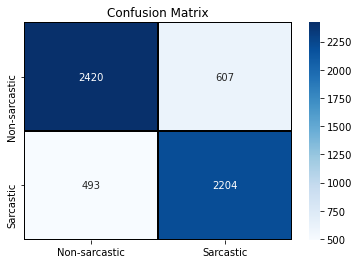

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_prediction), cmap= 'Blues', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'], 
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')